# Multi-TS Forecast

In this notebook we will generate the predictions for each time series filtered in the previous step using a hybrid approach. The method consists of a 2-step process where, first, trend and seasonality is fitted to each TS before it's residuals are persisted as the output variable of a 2nd model.
In the 2nd stage we fit a general model to prefict the (concatenated) residuals of all the time series fitted in the 1st stage. The input features for this 2nd model are the lagged residuals and its rolling statistics. Also in this 2nd model, to differentiate between TSs, we add the one-hot encoded categorical "group" variable.
The final prediction is the SUM of the predictions of the TS model in the 1st stage and the prediction corresponding to the same TS in the general 2nd stage model.

In [1]:
import os
os.chdir(os.environ['PWD'])

Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from app.conf import settings as sts
from app.conf import utils as uts
from app.conf import model_utils as muts
import re
import string
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
import json

#### Import Historical Data

In [3]:
dataset_filtered = uts.load_artifact('prices_dataframe', sts.LOCAL_ARTIFACTS_PATH)

In [4]:
dataset_filtered.head()

,date,group,product,market,mean_price
0,2013-01-01,carnes,alas de pollo con costillar,armenia mercar,NaN
1,2013-02-01,carnes,alas de pollo con costillar,armenia mercar,NaN
2,2013-03-01,carnes,alas de pollo con costillar,armenia mercar,NaN
3,2013-04-01,carnes,alas de pollo con costillar,armenia mercar,NaN
4,2013-05-01,carnes,alas de pollo con costillar,armenia mercar,NaN


Parse Date format and describe

In [5]:
dataset_filtered['date'] = pd.to_datetime(dataset_filtered['date'])

In [6]:
dataset_filtered['date'].describe(datetime_is_numeric=True)

count                 409320
mean     2017-12-15 23:12:00
min      2013-01-01 00:00:00
25%      2015-06-23 12:00:00
50%      2017-12-16 12:00:00
75%      2020-06-08 12:00:00
max      2022-12-01 00:00:00
Name: date, dtype: object

## Time Series Forecasting

Instance continuous dates series

In [7]:
date_range = pd.date_range(
    start = dataset_filtered['date'].min(), 
    end = dataset_filtered['date'].max(), 
    freq = 'MS'
)

Number of time series: Dataframe length / date range

In [8]:
n_series = dataset_filtered.shape[0] // date_range.shape[0]

Number of unique groups, products and markets

In [9]:
dataset_filtered['group'].nunique(), dataset_filtered['product'].nunique(), dataset_filtered['market'].nunique()

(8, 319, 72)

Assign each time series an ID

In [10]:
dataset_filtered['series_id'] = dataset_filtered.groupby(['group', 'product', 'market']).ngroup()

Define a Lambda function that creates a continuous date series starting from the input date (the first non-NULL value of a price series) and ending in the las recorded date in the consolidated DF

In [11]:
get_date_range = lambda start: pd.date_range(start = start, end = dataset_filtered['date'].max(), freq = 'MS')

Instance lists to persist the input and output variables of the 2nd stage model, based on the 1st stage models fitted to each separated TS

In [12]:
# Inputs 2nd model fit (in-sample)
multi_X_2 = []
# Inputs 2nd model prediction (out-of-sample)
multi_X_fore_2 = []
# Outputs 2nd model fit (in-sample)
multi_y_2 = []
# Series ID
series_id_series = []
# 1st model fitted-values
multi_y_pred_1 = []

In [13]:
predictions = {}

In [14]:
# For every Series ID ...
for series_id, series_df in tqdm(dataset_filtered.groupby('series_id')):
    series_df.set_index('date', inplace=True)
    # Extract Product Group
    group = series_df['group'].unique()[0]
    # Extract time series
    y = series_df['mean_price'].astype(float)
    # Get first non-null value index
    date_range_idx = get_date_range(y.first_valid_index())
    # Reindex TS
    y = y.reindex(date_range_idx).interpolate('linear')
    
    # Get in-sample and out-of-sample inputs for 1st-stage model
    X_1, X_fore_1 = muts.get_X_det(y, forecast_steps = 1)
    # Fit 1st-stage model: capture model, 1st stage model preds and 1st model residuals
    model_1, y_pred_1, residuals = muts.get_model(y, X_1, LinearRegression(), return_residuals = True)
    
    # Persist 1st stage model point forecast
    pred = {
        'index':X_fore_1.index[0],
        'point_det':model_1.predict(X_fore_1)[0]
    }
    predictions[series_id] = pred
    
    # Get 2nd stage input and outputs
    y_2, X_fore_2, X_2 = muts.get_X_res(residuals, 3)
    X_2['group'] = group
    X_fore_2['group'] = group
    
    # Persist 1st stage fitted and true values
    y_pred_frame_1 = y_pred_1.iloc[3:].to_frame()
    y_pred_frame_1['series_id'] = series_id
    y_pred_frame_1['y_true'] = y.iloc[3:]
    
    # Persist elements in lists
    multi_y_pred_1.append(y_pred_frame_1)
    multi_X_2.append(X_2)
    multi_X_fore_2.append(X_fore_2)
    multi_y_2.append(y_2)

100%|█████████████████████████████████████████████████████████████| 3411/3411 [00:32<00:00, 104.80it/s]


Concatenate elements in lists

In [15]:
multi_X_2 = pd.concat(multi_X_2)
multi_X_fore_2 = pd.concat(multi_X_fore_2)
multi_y_2 = pd.concat(multi_y_2)

multi_y_pred_1 = pd.concat(multi_y_pred_1)

In [16]:
forecast_date = X_fore_1.index[0].strftime('%Y-%m')

In [17]:
predictions[0]

{'index': Timestamp('2023-01-01 00:00:00', freq='MS'),
 'point_det': 12164.680508118698}

### 2nd Stage Model

Instance feature pipeline for 2nd stage / general model

In [18]:
feature_pipeline = ColumnTransformer(
    transformers=[
        ('group_onehot', OneHotEncoder(handle_unknown='ignore'), ['group']),
        ('numeric', 'passthrough', ['y_lag_1', 'y_lag_2', 'y_lag_3', 'y_rolling_std'])
    ],
)

Fit and transform 2nd stage model inputs

In [19]:
feature_pipeline.fit(multi_X_2)

ColumnTransformer(transformers=[('group_onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['group']),
                                ('numeric', 'passthrough',
                                 ['y_lag_1', 'y_lag_2', 'y_lag_3',
                                  'y_rolling_std'])])

In [20]:
trans_multi_X_2 = feature_pipeline.transform(multi_X_2)

In [21]:
trans_multi_X_2.shape

(377501, 12)

Fit 2nd stage model and get its fitted values

In [22]:
model_2, multi_y_pred_2 = muts.get_model(multi_y_2, trans_multi_X_2, KNeighborsRegressor(), return_residuals=False)

Get 1st stage and 2nd stage model(s) fitted values and sum them up

In [23]:
multi_y_pred_1.shape

(377501, 3)

In [24]:
multi_y_pred_2.shape

(377501,)

In [25]:
multi_y_pred_1['y_pred'] = multi_y_pred_2 + multi_y_pred_1[0]

Get general residuals from the general fitted values (1st stage + 2nd stage)

In [26]:
multi_y_pred_1['residuals'] = multi_y_pred_1['y_true'] - multi_y_pred_1['y_pred']

Compute general residual STD

In [27]:
std_preds = multi_y_pred_1.groupby(['series_id'])['residuals'].std().to_dict()

Predict 2nd stage model out-of-sample values

In [28]:
point_res = pd.Series(model_2.predict(feature_pipeline.transform(multi_X_fore_2)), index = np.arange(multi_X_fore_2.shape[0])).to_dict()

Consolidate predictions as the sum of point predictions in the 1st and 2nd stage models

In [29]:
final_predictions = {
    series_id:{
        'point_res': point_res[series_id],
        **predictions[series_id],
        'std': std_preds[series_id],
        'point': predictions[series_id]['point_det'] + point_res[series_id],
        'lower': predictions[series_id]['point_det'] + point_res[series_id] - 1.96 * std_preds[series_id],
        'upper': predictions[series_id]['point_det'] + point_res[series_id] + 1.96 * std_preds[series_id]
    }
    for series_id in np.arange(n_series)
}

Series example

In [69]:
series_id = 1604

In [70]:
final_predictions[series_id]

{'point_res': 51.31829054505893,
 'index': Timestamp('2023-01-01 00:00:00', freq='MS'),
 'point_det': 488.0706808146986,
 'std': 31.370158103826242,
 'point': 539.3889713597575,
 'lower': 477.9034614762581,
 'upper': 600.8744812432569}

In [71]:
series_df = dataset_filtered[dataset_filtered.series_id==series_id]
series_df.set_index('date', inplace=True)
group = series_df['group'].unique()[0]
y = series_df['mean_price']
date_range_idx = get_date_range(y.first_valid_index())
y = y.reindex(date_range_idx).interpolate()

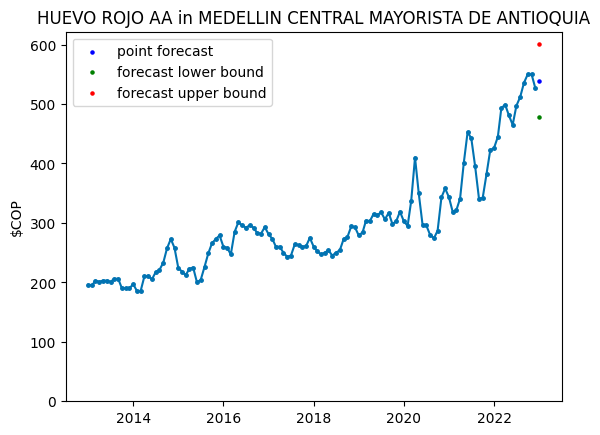

In [79]:
plt.plot(y, marker = '.', markersize=5)
plt.scatter(x = final_predictions[series_id]['index'],
            y = final_predictions[series_id]['point'], color = 'b',
            label = 'point forecast',
            s = 5)
plt.scatter(x = final_predictions[series_id]['index'],
            y = final_predictions[series_id]['lower'], color = 'g',
            label = 'forecast lower bound',
            s = 5)
plt.scatter(x = final_predictions[series_id]['index'],
            y = final_predictions[series_id]['upper'], color = 'r',
            label = 'forecast upper bound',
            s = 5)
plt.legend()
plt.ylim(bottom=0)
plt.title(f"{series_df['product'].iloc[0].upper()} in {series_df['market'].iloc[0].upper()}")
plt.ylabel("$COP")
plt.show()

#### Build routing dicts: 
1. series_to_id_dict: tuple(product, market) -> series_id
2. id_to_market_dict: series_id -> market
3. product_to_series_dict: product -> list(series_ids) product in different markets

In [34]:
series_to_id_dict = dataset_filtered[['product', 'market', 'series_id']].drop_duplicates().set_index(['product', 'market']).squeeze().to_dict()

In [35]:
len(series_to_id_dict)

3411

In [36]:
id_to_market_dict = {v:k[1] for k,v in series_to_id_dict.items()}

In [37]:
len(id_to_market_dict)

3411

In [38]:
product_to_series_dict = dataset_filtered[['product', 'series_id']].drop_duplicates().groupby(['product'])['series_id'].apply(lambda x: list(np.unique(x))).to_dict()

In [39]:
len(product_to_series_dict)

319

### Request Methods Examples

#### Multiple series for one product query

In [40]:
product = 'maracuya'

In [41]:
series_for_product = product_to_series_dict.get(product, [])

In [42]:
predictions = {}

In [43]:
for series_id in series_for_product:
    market = id_to_market_dict[series_id]
    predictions[market] = {
        'point': final_predictions[series_id]['point'],
        'lower': final_predictions[series_id]['lower'],
        'upper': final_predictions[series_id]['upper']
    }

In [44]:
predictions

{'arauca arauca': {'point': 3190.5051680537154,
  'lower': 2613.9313699147824,
  'upper': 3767.0789661926483},
 'armenia mercar': {'point': 3302.6021235540147,
  'lower': 2631.4892465720905,
  'upper': 3973.715000535939},
 'bogota dc corabastos': {'point': 3473.723557425532,
  'lower': 2242.040721722351,
  'upper': 4705.406393128713},
 'bucaramanga centroabastos': {'point': 3375.145136345196,
  'lower': 2586.763911210064,
  'upper': 4163.526361480328},
 'buenaventura valle del cauca': {'point': 3757.5284513980537,
  'lower': 3093.1761604269614,
  'upper': 4421.880742369146},
 'cali cavasa': {'point': 2991.5618801012392,
  'lower': 2246.211911698673,
  'upper': 3736.9118485038057},
 'cartago valle del cauca': {'point': 3471.6582921870627,
  'lower': 2733.1954768859396,
  'upper': 4210.121107488186},
 'chiquinquira boyaca': {'point': 3061.7526281752375,
  'lower': 1887.774522631735,
  'upper': 4235.73073371874},
 'cucuta cenabastos': {'point': 4007.318220114783,
  'lower': 3270.819253021

#### One series for one product-market query

In [45]:
product = 'maracuya'
market = 'bogota dc corabastos'

In [46]:
series_for_product_market = series_to_id_dict.get((product, market), -1)

In [47]:
series_for_product_market

1028

In [48]:
prediction = {
    'point': final_predictions[series_for_product_market]['point'],
    'lower': final_predictions[series_for_product_market]['lower'],
    'upper': final_predictions[series_for_product_market]['upper']
}

In [49]:
prediction

{'point': 3473.723557425532,
 'lower': 2242.040721722351,
 'upper': 4705.406393128713}

### Save Model object with predictions and dicts as artifact

In [50]:
routing_dicts = {
    'series_to_id_dict': series_to_id_dict,
    'id_to_market_dict': id_to_market_dict,
    'product_to_series_dict': product_to_series_dict
}

In [51]:
from app.conf.mymodel import MyModel

In [52]:
model = MyModel(final_predictions, routing_dicts, forecast_date)

In [53]:
model.predict_product('maracuya')

{'arauca arauca': {'point': 3190.5051680537154,
  'lower': 2613.9313699147824,
  'upper': 3767.0789661926483},
 'armenia mercar': {'point': 3302.6021235540147,
  'lower': 2631.4892465720905,
  'upper': 3973.715000535939},
 'bogota dc corabastos': {'point': 3473.723557425532,
  'lower': 2242.040721722351,
  'upper': 4705.406393128713},
 'bucaramanga centroabastos': {'point': 3375.145136345196,
  'lower': 2586.763911210064,
  'upper': 4163.526361480328},
 'buenaventura valle del cauca': {'point': 3757.5284513980537,
  'lower': 3093.1761604269614,
  'upper': 4421.880742369146},
 'cali cavasa': {'point': 2991.5618801012392,
  'lower': 2246.211911698673,
  'upper': 3736.9118485038057},
 'cartago valle del cauca': {'point': 3471.6582921870627,
  'lower': 2733.1954768859396,
  'upper': 4210.121107488186},
 'chiquinquira boyaca': {'point': 3061.7526281752375,
  'lower': 1887.774522631735,
  'upper': 4235.73073371874},
 'cucuta cenabastos': {'point': 4007.318220114783,
  'lower': 3270.819253021

In [54]:
model.predict_product_market('maracuya','medellin plaza minorista jose maria villa')

{'point': 2944.419396876094,
 'lower': 2391.1521608587063,
 'upper': 3497.686632893482}

In [55]:
model.get_model_info()

{'model_name': 'Next-Month Colombian Fruit and Veg Prices Predictor',
 'model_version': '1',
 'forecast_date': '2023-01'}

In [56]:
uts.dump_artifact(model, 'model', sts.LOCAL_ARTIFACTS_PATH)